### Notebook to create 3-panel plot with multiple datasets for BOWTIE overview.

James Ruppert  
jruppert@ou.edu  
12/16/24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import xarray as xr
import pandas as pd
from scipy import stats, signal
from bowtie_read_data import *
from time_series_diag import *
import seaborn as sns

### Read in data

#### Grab data from IPFS server

In [2]:
# # address = "http://127.0.0.1:8080/ipns/latest.orcestra-campaign.org/"
# # address = "ipns://latest.orcestra-campaign.org"
# # client = ipfshttpclient.connect(address)
# xr.open_dataset("ipns://latest.orcestra-campaign.org/products/HALO/bahamas/ql/HALO-20240811a.zarr",
#                 engine="zarr")


#### Local data

In [3]:
# Soundings
soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'ascen')
snd_vars = list(soundings.keys())[2:] # retain only 2-d variables in list

# Mask soundings that don't reach 100 hPa
soundings = mask_soundings(soundings, p_threshold=100)

# Radiometer data
cwv_rdm, times_rdm = read_bowtie_radiometer()

# Sun photometer data
photom = read_bowtie_sunphotometer()

# SeaSnake data
snakedat = read_bowtie_seasnake()

# DSHIP data
dship = read_bowtie_dship()

# IMERG rain
rain_imerg_mean, rain_imerg_max, times_imerg = read_bowtie_imerg_precip() # mm/hr

# AEW tracks
# aew_lon, aew_lat, times_aew = read_aew_tracks()

/Users/jamesruppert/Library/CloudStorage/OneDrive-UniversityofOklahoma/piccolo-data/bowtie_read_data.py:36: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(soundings['p'][isnd,:]*1e-2) # Pa --> hPa


#### Smooth data

In [28]:
def do_smooth(invar, times, nhr_smooth=1):
    dt = np.diff(times).mean()
    dt = np.timedelta64(dt, 's')
    nt_smooth = int(nhr_smooth*60*60 / dt.astype(np.float64))
    if nt_smooth <= 1:
        return invar
    else:
        invar_df = pd.DataFrame(invar)
        return np.squeeze(invar_df.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean())

### Compute diagnostics

In [29]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    invar_masked = np.copy(invar)
    invar_masked[np.where(p < minpres)] = np.nan
    var_int = np.nansum(invar_masked*rho, axis=1)*dz
    # for iz in range(len(hght)):
    #     print(snd_asc['p'][15,iz])
    var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
    return var_int

In [30]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(soundings['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(soundings['mr'], soundings['tmpk'], soundings['mr'], soundings['p'],
                    soundings['hght'], minpres=0) # mm or kg/m2
                    # hght, minpres=60000) # mm or kg/m2

#### Mask out soundings that don't reach 100 hPa

In [31]:
# First save minimum pressure
nt = soundings['p'].shape[0]
minpres_tser = np.zeros(nt)
for it in range(nt):
    minpres_tser[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa
# minpres_tser[np.where(minpres > pmax)]=pmax-1

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_89509/1666208737.py:5: RuntimeWarning: All-NaN slice encountered
  minpres_tser[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa


### Find radiometer bias

In [32]:
# XX Get an array of times in sec for both datasets from some consistent baseline
t_start = np.datetime64('2024-08-17T00')
# t_end = times_rdm.max()
t_end = times_snd.max()
t_ind_snd = np.where((times_snd >= t_start) & (times_snd <= t_end))[0]
# t_ind_rdm = np.where((times_rdm >= t_start) & (times_rdm <= t_end))[0]
# times_asc_sec = (times_snd[t_ind_snd]-t_start)/np.timedelta64(1, 's')
# times_rdm_sec = (times_rdm[t_ind_rdm]-t_start)/np.timedelta64(1, 's')

# First smooth radiometer data to 3-hourly for consistent sampling with soundings
# using running average
nt_sm = np.timedelta64(3*60, 'm') # 3-hr rolling average
dt_rdm = times_rdm[1]-times_rdm[0]
nt_smooth = int(nt_sm/dt_rdm)
cwv_rdm_pd = pd.DataFrame(cwv_rdm)
cwv_rdm_sndsmooth = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth).mean()
# cwv_rdm_sndsmooth = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth,
#                                         win_type='cosine').mean()
cwv_rdm_sndsmooth = np.squeeze(cwv_rdm_sndsmooth)

# Then interpolate onto sounding times to be able to take difference
# cwv_sndinterp = np.interp(times_asc_sec, times_rdm_sec, cwv_rdm_sm[t_ind_rdm])
cwv_sndinterp = np.interp((times_snd[t_ind_snd].astype('datetime64[ns]')).astype(np.float64),
                       (times_rdm.astype('datetime64[ns]')).astype(np.float64), cwv_rdm_sndsmooth)

bias = np.nanmean(cwv[t_ind_snd]) - np.nanmean(cwv_sndinterp)
print('Bias:', bias, 'mm')

Bias: 5.196109049355442 mm


---
### Plotting routines

#### Plotting functions

In [33]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
sns.set_theme(style="ticks", rc={'xtick.bottom': True, 'ytick.left': True})#, "axes.spines.right": False, "axes.spines.top": False})
# sns.set_theme(style="dark")

In [34]:
def plot_time_series(figdata, scatter=True, axline=False):
    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_ylabel(figdata['ylabel'])
    ax.set_xlabel('Date')

    sizes=20

    finite=np.where(np.isfinite(figdata['pltvar']))
    ax.plot(figdata['time'][finite], figdata['pltvar'][finite], color='black', zorder=1)#, linewidth=1.0)
    if scatter:
        ax.scatter(figdata['time'], figdata['pltvar'], s=sizes, zorder=2)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    if axline:
        ax.axhline(y=figdata['axline'], color='black', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

In [35]:
def plot_cwv_comparison(plt, ax, figdata, axline=False, xlim=None):

    ax.set_title(figdata['fig_title'])
    # ax.set_xlabel('Date')
    ax.set_ylabel('kg m$^{-2}$')
    ax.set_ylim(figdata['ylim'])

    ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
    ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

    # t_max=np.max(figdata['time1'][-1])
    # if 'time2' in figdata:
    #     t_max=np.max((t_max,figdata['time2'][-1]))
    # if 'time3' in figdata:
    #     t_max=np.max((t_max,figdata['time3'][-1]))
    # # t_max=np.max((figdata['time1'][-1],figdata['time2'][-1],figdata['time3'].iloc[-1]))
    # ax.set_xlim((figdata['time1'][0],t_max))
    if xlim is not None:
        ax.set_xlim(xlim)
    # ax.set_xlim((figdata['time1'][-8],t_max))

    # color1='#ff7f50'#'red'
    color1='red'
    color2='black'
    color3='#00008B'

    linewidth=1

    sizes=20
    ax.scatter(figdata['time1'], figdata['pltvar1'], label=figdata['label1'], s=sizes, zorder=1, c=color1, alpha=0.5)
    if 'pltvar2' in figdata:
        ax.plot(figdata['time2'], figdata['pltvar2'], color=color2, zorder=2, alpha=0.5,
                label=figdata['label2'], linewidth=linewidth)
    if 'pltvar3' in figdata:
        sizes=np.full(len(figdata['time3']), 20)
        ax.scatter(figdata['time3'], figdata['pltvar3'], s=sizes, zorder=3, c=color3, alpha=0.5,
                label=figdata['label3'])

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    if axline:
        ax.axhline(y=figdata['axline'], color='black', linestyle='--', linewidth=0.8, zorder=0)

    ax.legend(loc='lower center')

    return

In [36]:
def plot_sst_time_series(figdata, ax, xlim=None):

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel(figdata['units_sst'])
    # ax.set_xlabel('Date [UTC]')
    if xlim is not None:
        ax.set_xlim(xlim)
    # ax.set_ylim((28,29.5))

    ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
    ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

    linewidth=1.5
    ax.plot(figdata['time_dship'], figdata['thermo_sst'], label='Thermosalinograph', color='#1f77b4', linewidth=linewidth)
    # ax.plot(figdata['time_dship'], sst, label='Station', linewidth=linewidth)
    ax.plot(figdata['time_snake'], figdata['snake_sst'], label='SeaSnake', color='#ff7f50', linewidth=linewidth)
    # ax.plot(figdata['time_isar'], figdata['isar_sst'], label='ISAR', color='#2ca02c', linewidth=linewidth)

    ax2 = ax.twinx()
    # ax2.plot(figdata['time_dship'], figdata['snake_sst'] - figdata['thermo_sst'], label='Snake', linewidth=linewidth)
    linewidth=1.
    ax2.plot(figdata['time_dship'], figdata['wspd'], label='Wind speed', color='black', linewidth=linewidth, alpha=0.5, zorder=0)
    # ax2.plot(figdata['time_dship'], wspd_daily, label='24hAvg', color='black', linewidth=linewidth, alpha=1, zorder=0)
    ax2.set_ylabel(figdata['units_var2'])

    # ax2.plot(figdata['time_dship'], wspd - wspd_daily, label='Wind speed', color='red', linewidth=linewidth, alpha=0.4, zorder=0)

    ax.legend(fontsize=10, loc='upper left')#frameon=False)
    ax2.legend(fontsize=10, loc='upper right')#frameon=False)

    ax2.grid(visible=False)#, axis='x')

    # Time labels
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    return

In [37]:
def plot_rain_time_series(figdata, ax, axline=False, xlim=None):

    ax.set_title(figdata['fig_title'])
    ax.set_xlabel('Date [UTC]')

    ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
    ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

    if xlim is not None:
        ax.set_xlim(xlim)
    
    ax.set_ylim(figdata['ylim1'])

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    color1='#ff7f50'
    color2='#1f77b4'

    linewidth=1.5
    ax.plot(figdata['time'], figdata['pltvar1'], label=figdata['label1'], color=color1, zorder=1, linewidth=linewidth)
    ax.set_ylabel("mm/hr")

    if axline:
        ax.axhline(y=figdata['axline'], color='black', linewidth=0.8, zorder=0)

    ax2 = ax.twinx()
    linewidth=1
    ax2.plot(figdata['time'], figdata['pltvar2'], label=figdata['label2'], color=color2, linewidth=linewidth, zorder=0)#, alpha=0.7)
    ax2.set_ylim(figdata['ylim2'])
    ax2.set_ylabel("mm/hr")
    ax2.grid(visible=False)

    # ax2.plot(figdata['time_dship'], wspd - wspd_daily, label='Wind speed', color='red', linewidth=linewidth, alpha=0.4, zorder=0)

    ax.legend(fontsize=10, loc='upper left')#frameon=False)
    ax2.legend(fontsize=10, loc='upper right')#frameon=False)

    return

#### Minimum sounding pressure

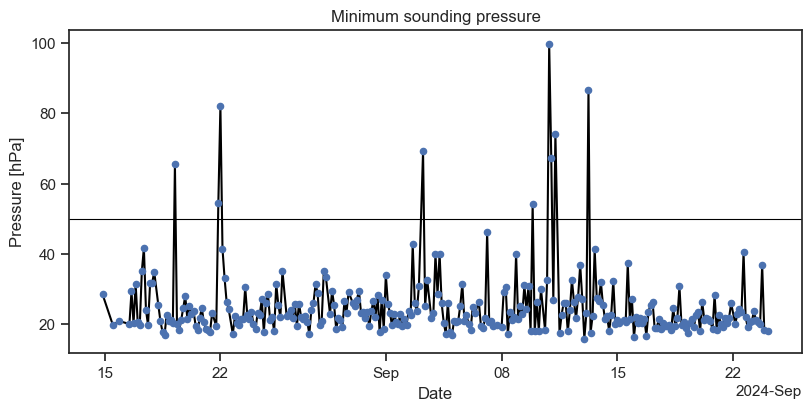

In [38]:
figdata={
    'pltvar': minpres_tser,
    'time': times_snd,
    'title': 'Minimum sounding pressure',
    'ylabel': 'Pressure [hPa]',
    'axline': 50,
    }

plot_time_series(figdata, axline=True)

#### Data set comparison

#### 3-panel

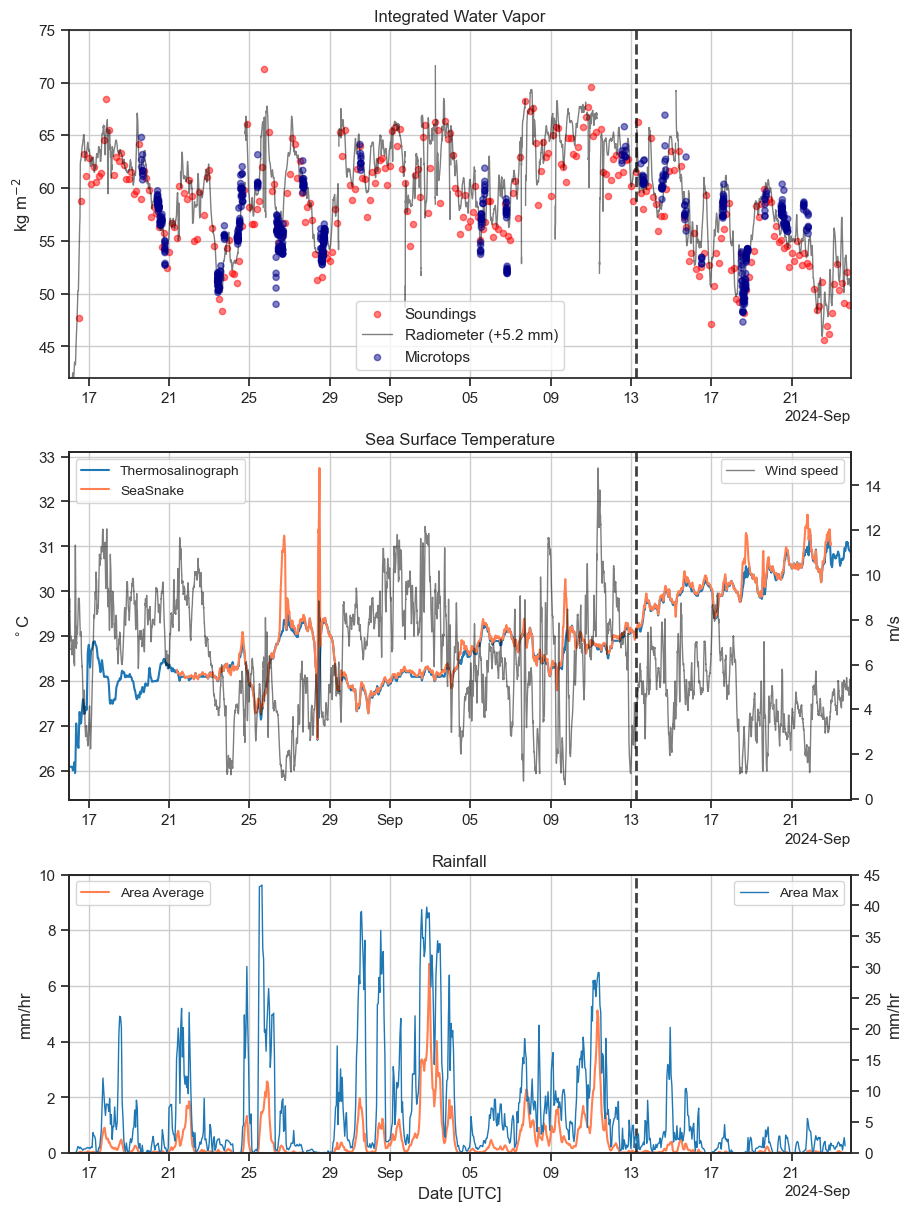

In [39]:
# xlim = (snakedat[0].iloc[0], snakedat[0].iloc[-1])
xlim = (np.datetime64('2024-08-16T00'), dship['time'][-1])

fig_x = 9
fig_y = 12
fig, axs = plt.subplots(3, 1, figsize=(fig_x,fig_y), 
                        # height_ratios=[3,3,3,3,1.8], 
                        height_ratios=[3.5,3.5,2.8],
                        layout='constrained',squeeze=True)

# CWV

figdata={
    'fig_title': 'Integrated Water Vapor',
    'pltvar1': cwv,
    'pltvar2': do_smooth(cwv_rdm, times_rdm)+bias,
    # 'pltvar2': cwv_rdm+bias,
    # 'pltvar2': cwv_rdm,
    # 'pltvar2': cwv_rdm_sm,
    'pltvar3': photom['Water Vapor(cm)'],
    'time1': times_snd,
    'time2': times_rdm,
    'time3': np.array(photom['Date(dd:mm:yyyy)']),
    'label1': 'Soundings',
    'label2': 'Radiometer (+'+str(np.round(bias,decimals=2))+' mm)',
    # 'label2': 'Radiometer',
    'label3': 'Microtops',
    'axline': 48,
    'ylim': (42, 75),
    }

plot_cwv_comparison(plt, axs[0], figdata, axline=False, xlim=xlim)

# SST

figdata = {
    'fig_title': 'Sea Surface Temperature',
    'snake_sst': do_smooth(snakedat[4], snakedat[0]),
    'time_snake': snakedat[0],
    'units_sst': r'$^\circ$C',
    'thermo_sst': do_smooth(dship['sst1']-273.15, dship['time']),
    'wspd': do_smooth(dship['wspd'], dship['time']),
    'units_var2': 'm/s',
    'time_dship': dship['time'],
    # 'isar_sst': isar_sst-273.15,
    # 'time_isar': times_isar,
    # 'units2': r'$^\circ$C',
           }

plot_sst_time_series(figdata, axs[1], xlim=xlim)

# Rainfall

figdata = {
    'fig_title': 'Rainfall',
    # 'pltvar1': rain_imerg_mean,
    'pltvar1': do_smooth(rain_imerg_mean, times_imerg),
    # 'pltvar2': rain_imerg_max,
    'pltvar2': do_smooth(rain_imerg_max, times_imerg),
    'label1': 'Area Average',
    'label2': 'Area Max',
    'time': times_imerg,
    'ylim1': (0, 10),
    'ylim2': (0, 45),
           }

plot_rain_time_series(figdata, axs[2], xlim=xlim)

# Add line for when we crossed 40ºW
# Locate time when we crossed -40.0 in longitude
lon_cross = -40.0
lon_cross_ind = np.where(soundings['lon'][:] < lon_cross)[0][0]
soundings['lon'][lon_cross_ind]
for ax in axs:
    ax.axvline(x=times_snd[lon_cross_ind], color='black', linewidth=2, linestyle='--', alpha=0.75)

# # Shade subpanels for three different time periods
# end1 = np.datetime64('2024-09-05T00', 'h')
# end2 = np.datetime64('2024-09-14T00', 'h')
# gap = np.timedelta64(1, 'h')
# periods = [
#     (xlim[0], end1-gap, 'grey'),
#     (end1, end2-gap, 'blue'),
#     (end2, xlim[1], 'red'),
# ]
# for period in periods:
#     for ax in axs:
#         ax.axvspan(period[0], period[1], color=period[2], alpha=0.085)

# # Add labels to top panel
# yval=73.5
# xmean = np.mean((xlim[0].astype('datetime64[ns]').astype(np.float64), end1.astype('datetime64[ns]').astype(np.float64))).astype('datetime64[ns]')
# axs[0].text(xmean, yval, 'Eastern', horizontalalignment='center', verticalalignment='center', fontsize=12, zorder=3, weight='bold')
# xmean = np.mean((end1.astype('datetime64[ns]').astype(np.float64), end2.astype('datetime64[ns]').astype(np.float64))).astype('datetime64[ns]')
# axs[0].text(xmean, yval, 'Central', horizontalalignment='center', verticalalignment='center', fontsize=12, zorder=3, weight='bold')
# xmean = np.mean((end2.astype('datetime64[ns]').astype(np.float64), xlim[1].astype('datetime64[ns]').astype(np.float64))).astype('datetime64[ns]')
# axs[0].text(xmean, yval, 'Western', horizontalalignment='center', verticalalignment='center', fontsize=12, zorder=3, weight='bold')

plt.show()
plt.close()